In [13]:
import os
from PIL import Image
import glob

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
def load_dataset():
    # Train set
    train_images = []
    train_labels = []
    i = 0
    for folder in glob.iglob("./dataset/train/*"):
        for file in glob.iglob(f"{folder}/*"):
            train_images.append(np.asarray(Image.open(file)))
            train_labels.append(np.asarray(i))
        i += 1
    
    # Test set
    test_images = []
    test_labels = []
    i = 0
    for folder in glob.iglob("./dataset/test/*"):
        for file in glob.iglob(f"{folder}/*"):
            test_images.append(np.asarray(Image.open(file)))
            test_labels.append(np.asarray(i))
        i += 1
        
    train_images = np.asarray(train_images)
    train_labels = to_categorical(train_labels, 10)
    
    test_images = np.asarray(test_images)
    test_labels = to_categorical(test_labels, 10)
    
    return train_images, test_images, train_labels, test_labels

In [92]:
x_train, x_test, y_train, y_test = load_dataset()

In [93]:
def normalize_images(img):
    img_normalized = cv.normalize(img, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    return img_normalized

In [94]:
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

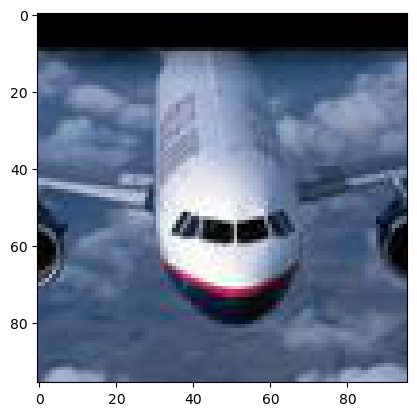

In [95]:
plt.imshow(x_test[1])

In [133]:
# Load autoencoder model
autoencoder = keras.models.load_model("./model_weights/multicolor/3-3-256")

In [134]:
autoencoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 48, 48, 32)        2432      
_________________________________________________________________
batch_normalization_146 (Bat (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_147 (Bat (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_148 (Bat (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 6, 6, 128)       

In [135]:
def create_encoder(autoencoder, depth):
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))
    
    for layer in autoencoder.layers[:depth]:
        model.add(layer)
    
    return model

In [137]:
# Separate encoder
encoder = create_encoder(autoencoder, 8)
encoder.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 48, 48, 32)        2432      
_________________________________________________________________
batch_normalization_146 (Bat (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_147 (Bat (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_148 (Bat (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 6, 6, 128)       

In [138]:
# Encode training and test data
x_train_embeddings = encoder.predict(x_train)
x_test_embeddings = encoder.predict(x_test)

In [142]:
def build_classifier(embedding_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Input(shape=embedding_shape))
    
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
    
    # Dense
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation="sigmoid"))
    model.add(layers.Softmax())
    
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    return model

In [143]:
model = build_classifier((6, 6, 128), dropout_rate=0.3)
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 3, 3, 256)         1024      
_________________________________________________________________
dropout_72 (Dropout)         (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 512)         1180160   
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 1, 1, 512)       

In [144]:
early_stopping_monitor = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.005,
    patience=40,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(
    x=x_train_embeddings,
    y=y_train,
    batch_size=64,
    epochs=100,
    callbacks=[early_stopping_monitor],
    validation_data=(x_test_embeddings, y_test)
)

Epoch 1/100
157/157 [==============================] - 4s 14ms/step - loss: 2.1188 - categorical_accuracy: 0.2595 - val_loss: 2.1891 - val_categorical_accuracy: 0.1827
Epoch 2/100
157/157 [==============================] - 2s 13ms/step - loss: 1.9813 - categorical_accuracy: 0.3434 - val_loss: 2.0091 - val_categorical_accuracy: 0.3170
Epoch 3/100
157/157 [==============================] - 2s 12ms/step - loss: 1.9260 - categorical_accuracy: 0.3885 - val_loss: 1.9224 - val_categorical_accuracy: 0.3830
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 1.8847 - categorical_accuracy: 0.4067 - val_loss: 1.8998 - val_categorical_accuracy: 0.4093
Epoch 5/100
157/157 [==============================] - 2s 13ms/step - loss: 1.8488 - categorical_accuracy: 0.4418 - val_loss: 1.8832 - val_categorical_accuracy: 0.4377
Epoch 6/100
157/157 [==============================] - 2s 12ms/step - loss: 1.8208 - categorical_accuracy: 0.4702 - val_loss: 1.8766 - val_categorical_accuracy:

In [89]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Summarize history for accuracy
    ax[0].plot(history.history['categorical_accuracy'])
    ax[0].plot(history.history['val_categorical_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='upper left')

    # Summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper left')

    fig.tight_layout(pad=5.0)
    plt.show()

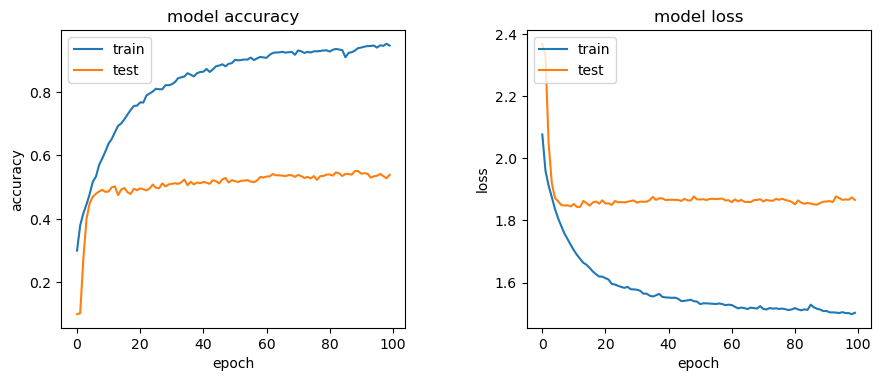

In [103]:
plot_history(history)

In [85]:
def build_combined_model(encoder, classifier, dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 1)))
    
    for layer in encoder.layers:
        model.add(layer)
    
    for layer in classifier.layers:
        model.add(layer)
    
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    return model

In [86]:
combined_model = build_combined_model(encoder, model)
combined_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_18 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)        

In [87]:
early_stopping_monitor = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.005,
    patience=40,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

history = combined_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    callbacks=[early_stopping_monitor],
    validation_data=(x_test, y_test)
)

Epoch 1/100
157/157 [==============================] - 54s 28ms/step - loss: 1.6672 - categorical_accuracy: 0.6978 - val_loss: 1.9882 - val_categorical_accuracy: 0.3707
Epoch 2/100
157/157 [==============================] - 4s 24ms/step - loss: 1.6551 - categorical_accuracy: 0.7075 - val_loss: 1.9669 - val_categorical_accuracy: 0.3967
Epoch 3/100
157/157 [==============================] - 4s 24ms/step - loss: 1.6351 - categorical_accuracy: 0.7436 - val_loss: 1.9115 - val_categorical_accuracy: 0.4487
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 1.6427 - categorical_accuracy: 0.7378 - val_loss: 1.9172 - val_categorical_accuracy: 0.4507
Epoch 5/100
157/157 [==============================] - 4s 24ms/step - loss: 1.6386 - categorical_accuracy: 0.7437 - val_loss: 1.9635 - val_categorical_accuracy: 0.3977
Epoch 6/100
157/157 [==============================] - 4s 24ms/step - loss: 1.6354 - categorical_accuracy: 0.7410 - val_loss: 1.9218 - val_categorical_accuracy

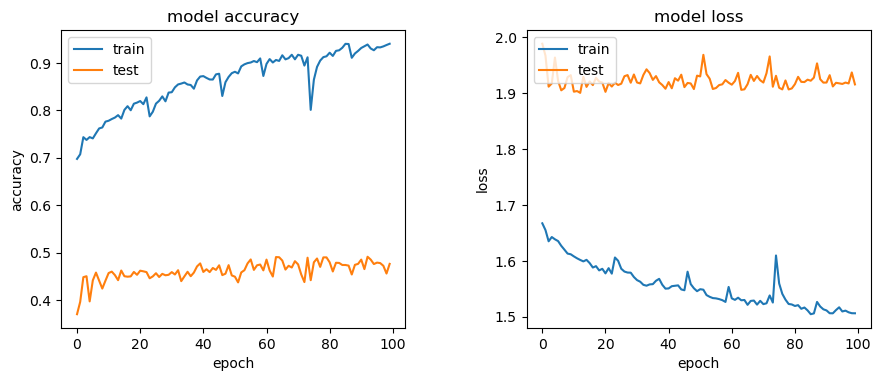

In [91]:
plot_history(history)